<a href="https://colab.research.google.com/github/jaysonlam/diabetes_prediction/blob/main/Diabetes_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/dataset/

Mounted at /content/drive/
/content/drive/MyDrive/dataset


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,LabelEncoder,RobustScaler,OneHotEncoder,PowerTransformer
from sklearn.model_selection import KFold,StratifiedKFold, train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
data = pd.read_csv('nhgh.tsv', sep='\t')
data = data.drop(["seqn"], axis=1)

In [4]:
data

,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
0,male,34.166667,Non-Hispanic White,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94
1,male,16.833333,Non-Hispanic Black,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89
2,female,60.166667,Non-Hispanic Black,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11
3,male,26.083333,Mexican American,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80
4,female,49.666667,Non-Hispanic White,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,male,33.000000,Mexican American,"[35000,45000)",0,0,94.3,163.5,35.28,34.4,34.7,35.5,112.3,20.2,NaN,5.4,4.1,10.0,0.97
6791,female,48.916667,Non-Hispanic White,"[0,5000)",0,1,87.1,156.9,35.38,33.9,34.5,37.0,99.4,28.6,25.4,5.5,4.1,7.0,0.89
6792,male,27.500000,Other Hispanic,"[35000,45000)",0,0,57.0,164.3,21.12,35.3,33.7,29.6,73.2,4.2,6.8,5.6,4.5,11.0,0.94
6793,male,75.750000,Non-Hispanic Black,"[10000,15000)",0,0,75.1,162.7,28.37,38.6,36.8,31.2,104.0,19.8,21.1,5.4,4.0,19.0,1.34


In [5]:
na_count_per_column = data.isna().sum()
print("NA count in each column:")
print(na_count_per_column)

NA count in each column:
sex          0
age          0
re           0
income     320
tx           0
dx           0
wt           0
ht           0
bmi          0
leg        231
arml       179
armc       188
waist      239
tri        481
sub        971
gh           0
albumin     89
bun         89
SCr         89
dtype: int64


Convert gh to binary value to indicate diabetic patients

In [6]:
data["gh"] = data["gh"].apply(lambda x: 1 if x>=6.5 else 0)

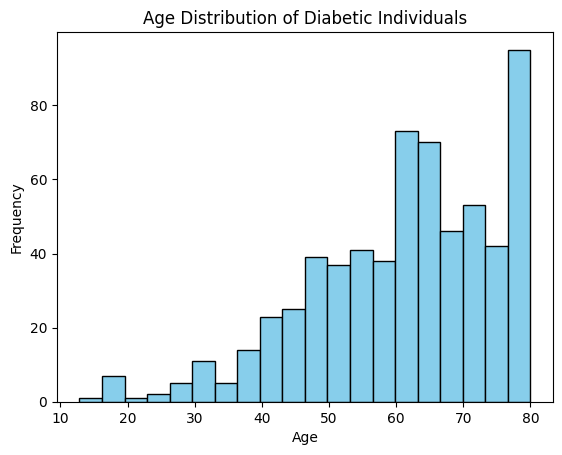

In [7]:
diabetic_data = data[data['gh'] == 1]
plt.hist(diabetic_data['age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Diabetic Individuals')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

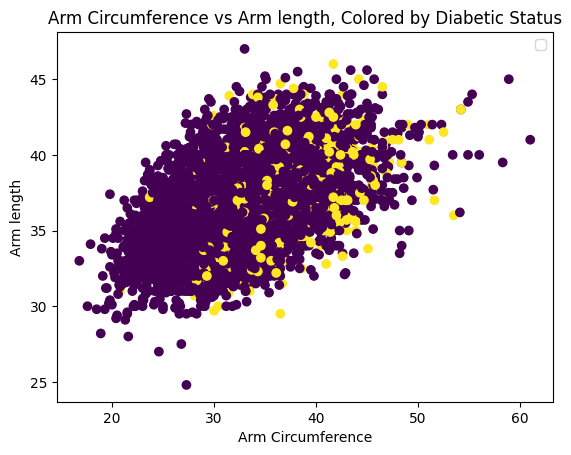

In [12]:
plt.scatter(data['armc'], data['arml'], c=data['gh'], cmap='viridis')
plt.xlabel('Arm Circumference')
plt.ylabel('Arm length')
plt.title('Arm Circumference vs Arm length, Colored by Diabetic Status')
_ = plt.legend()

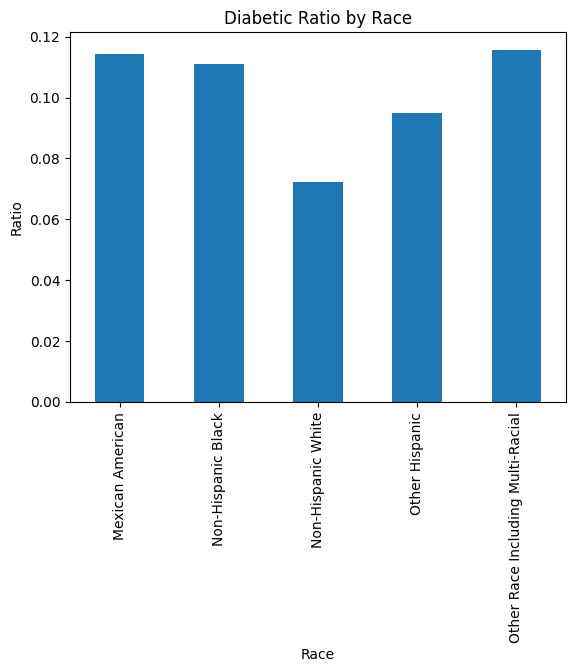

In [666]:
gh_counts = data['gh'].groupby(data['re']).mean()
gh_counts.plot(kind='bar')
plt.title('Diabetic Ratio by Race')
plt.xlabel('Race')
_ = plt.ylabel('Ratio')

<ipython-input-616-55ebd5b11dbd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


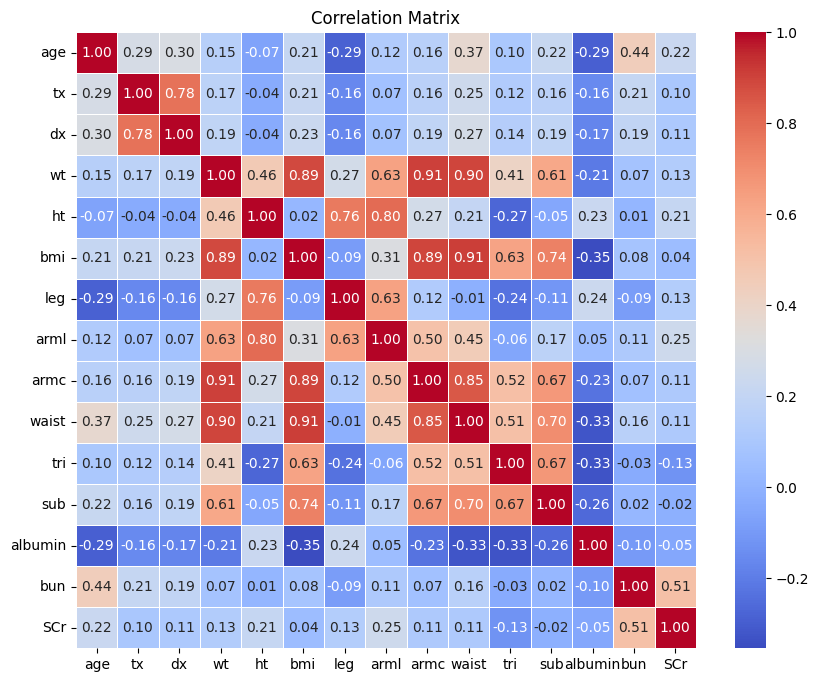

In [616]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Possible features to remove are wt,armc,waist due to high correlation with bmi

In [617]:
y = data["gh"]
y_values_count = y.value_counts()
print("Number of each value in gh column:")
print(y_values_count)

Number of each value in gh column:
0    6167
1     628
Name: gh, dtype: int64


#Preprocessing Pipeline

In [618]:
num_pipeline = Pipeline([
    ('impute', KNNImputer()),
])

In [619]:
cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encode', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [620]:
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
num_cols = data.select_dtypes(exclude=['object']).columns.tolist()

In [621]:
data_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_cols),
    ('categorical', cat_pipeline, cat_cols),
])

## Code to handle class imbalance

In [622]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.pipeline import Pipeline as ResamplingPipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# resampling_pipeline = ResamplingPipeline([
#     ('preprocessing', data_pipeline),
#     ('undersample', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
#     #('upsample', RandomOverSampler(random_state=42)),
#     ('SMOTE',SMOTE(random_state=42))
# ])

# pre_X_train, pre_X_test, pre_y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)
# X_train, y_train = resampling_pipeline.fit_resample(pre_X_train, pre_y_train)
# X_test = pd.DataFrame(data=data_pipeline.fit_transform(pre_X_test))

In [623]:
data = data.drop("gh", axis=1)
transformed_data = pd.DataFrame(data=data_pipeline.fit_transform(data))
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42)
feature_names = data_pipeline.get_feature_names_out()

In [624]:
y_train.value_counts()

0    4943
1     493
Name: gh, dtype: int64

In [625]:
y_test.value_counts()

0    1224
1     135
Name: gh, dtype: int64

In [626]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Logistic Regression

Best hyperparameters: {'logistic_regression__C': 10, 'logistic_regression__penalty': 'l2', 'logistic_regression__solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1224
           1       0.71      0.63      0.67       135

    accuracy                           0.94      1359
   macro avg       0.84      0.80      0.82      1359
weighted avg       0.94      0.94      0.94      1359



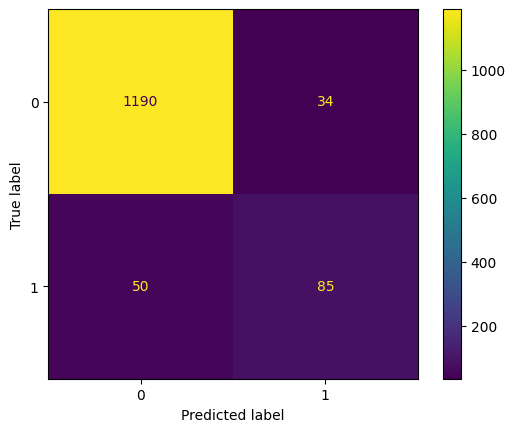

In [627]:
lr = Pipeline([('logistic_regression',LogisticRegression(random_state=42))])

# Define hyperparameters for grid search
param_grid = {
    'logistic_regression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'logistic_regression__penalty': ['l2'],
    'logistic_regression__C': [0.001, 0.01, 0.1, 1, 10,100]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(lr, param_grid, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_lr = grid_search.best_estimator_
coefficients = best_lr.named_steps['logistic_regression'].coef_

# Predictions on the test set
y_pred = best_lr.predict(X_test)

# Print model details
print("Best hyperparameters:", grid_search.best_params_)

# Additional evaluation metrics
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [628]:
# Print the sorted coefficients with feature names
coefficients_with_names = list(zip(feature_names, coefficients[0]))
sorted_coefficients = sorted(coefficients_with_names, key=lambda x: abs(x[1]), reverse=True)
print("Ranked coefficients:")
for feature, coefficient in sorted_coefficients:
    print(f"{feature}: {coefficient}")


Ranked coefficients:
numerical__tx: 2.0698127591938706
numerical__dx: 1.6412729582330456
categorical__income_[0,5000): -0.9455440039511556
numerical__albumin: -0.7751625081296445
categorical__re_Non-Hispanic White: -0.5524868744978187
categorical__income_missing: 0.5215535638925823
categorical__re_Other Race Including Multi-Racial: 0.49542524159723744
categorical__income_[25000,35000): 0.36460494834044965
numerical__SCr: -0.2995481574350923
categorical__re_Mexican American: 0.2933669970260728
categorical__sex_female: -0.25498151077436326
categorical__sex_male: 0.24599188306824638
categorical__income_[10000,15000): -0.19832620637880294
categorical__income_[35000,45000): 0.1931977051199681
categorical__income_> 20000: 0.15097057408458328
categorical__re_Non-Hispanic Black: -0.14888380261205314
numerical__bmi: -0.13030599023073325
categorical__income_[55000,65000): -0.12790753530225596
categorical__income_[15000,20000): -0.1236144240965532
categorical__income_[5000,10000): 0.1207315542729

# Decision Tree

Best Hyperparameters: {'ccp_alpha': 0.0007725203293579772, 'criterion': 'gini', 'max_depth': 3, 'max_features': None}
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1224
           1       0.72      0.72      0.72       135

    accuracy                           0.94      1359
   macro avg       0.84      0.84      0.84      1359
weighted avg       0.94      0.94      0.94      1359



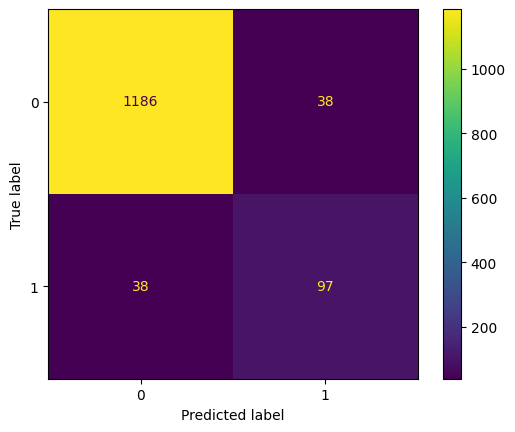

In [629]:
dt = DecisionTreeClassifier(random_state=42)

# Get cost-complexity pruning path
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Define hyperparameters for grid search
param_grid = {
    'ccp_alpha': ccp_alphas,
    'max_depth': [None, 2, 3, 5],
    'criterion': ["gini", "entropy"],
    'max_features': ['sqrt', 'log2', None],
}

# Perform grid search cross-validation
grid_search = GridSearchCV(dt, param_grid, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
best_dt = grid_search.best_estimator_
best_alpha = best_dt.ccp_alpha
best_hyperparams = grid_search.best_params_

# Predictions on the test set
y_pred = best_dt.predict(X_test)

# Print model details
print("Best Hyperparameters:",best_hyperparams)

# Additional evaluation metrics
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

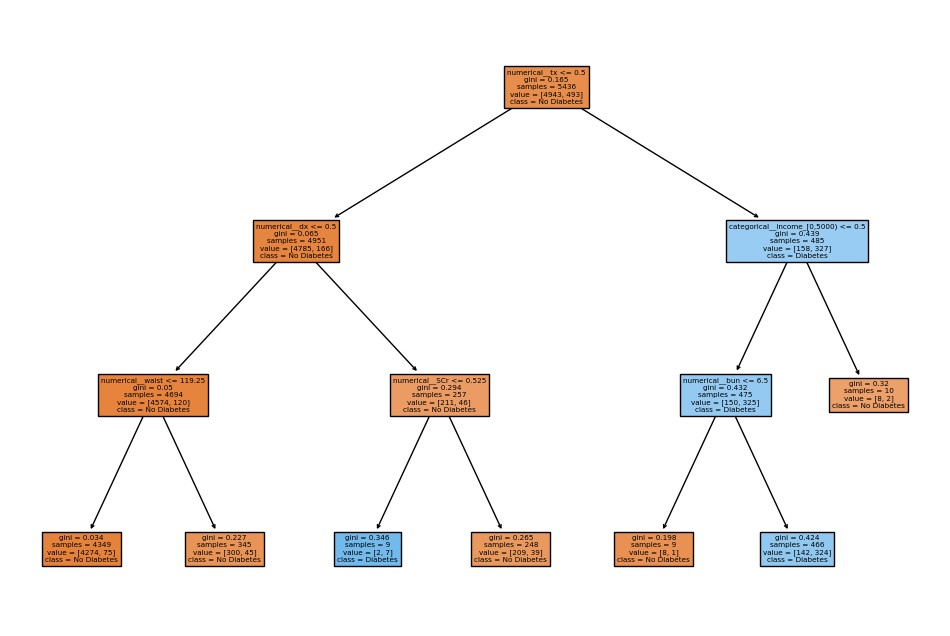

In [630]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Plot decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_dt, filled=True, feature_names=feature_names, class_names=['No Diabetes', 'Diabetes'])
plt.show()

In [631]:
# Display feature importances
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature Importances:")
for i, idx in enumerate(indices):
    if importances[idx]==0:
      break
    print(f"{i + 1}. {feature_names[idx]}: {importances[idx]}")

Feature Importances:
1. numerical__tx: 0.9074922515700354
2. numerical__dx: 0.0287044537833756
3. numerical__waist: 0.020495470832087047
4. numerical__SCr: 0.016736047569147646
5. numerical__bun: 0.015079634018240246
6. categorical__income_[0,5000): 0.011492142227114205


Best parameters: {'ccp_alpha': 0.05, 'max_depth': None, 'max_features': None, 'n_estimators': 25}
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1224
           1       0.73      0.75      0.74       135

    accuracy                           0.95      1359
   macro avg       0.85      0.86      0.85      1359
weighted avg       0.95      0.95      0.95      1359



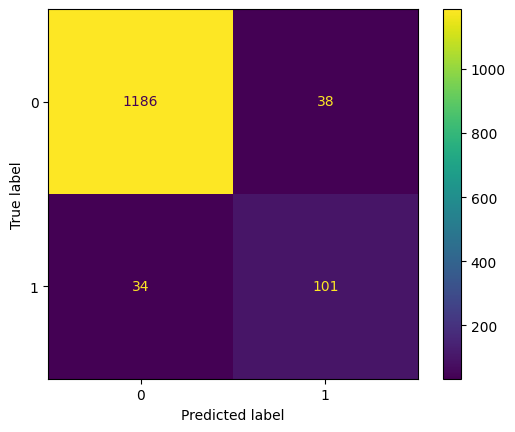

In [632]:
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [25,50],
    'max_depth': [None, 2, 3 ,5],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.05]
}

# param_grid = {
#     'n_estimators': [25,50,100],
#     'max_depth': [None, 2, 3 ,5],
#     'max_features': ['sqrt', 'log2', None],
#     'ccp_alpha': [0.05,0.1,0.15]
# }


# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Predictions on the test set
y_pred = best_rf.predict(X_test)

# Additional evaluation metrics
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

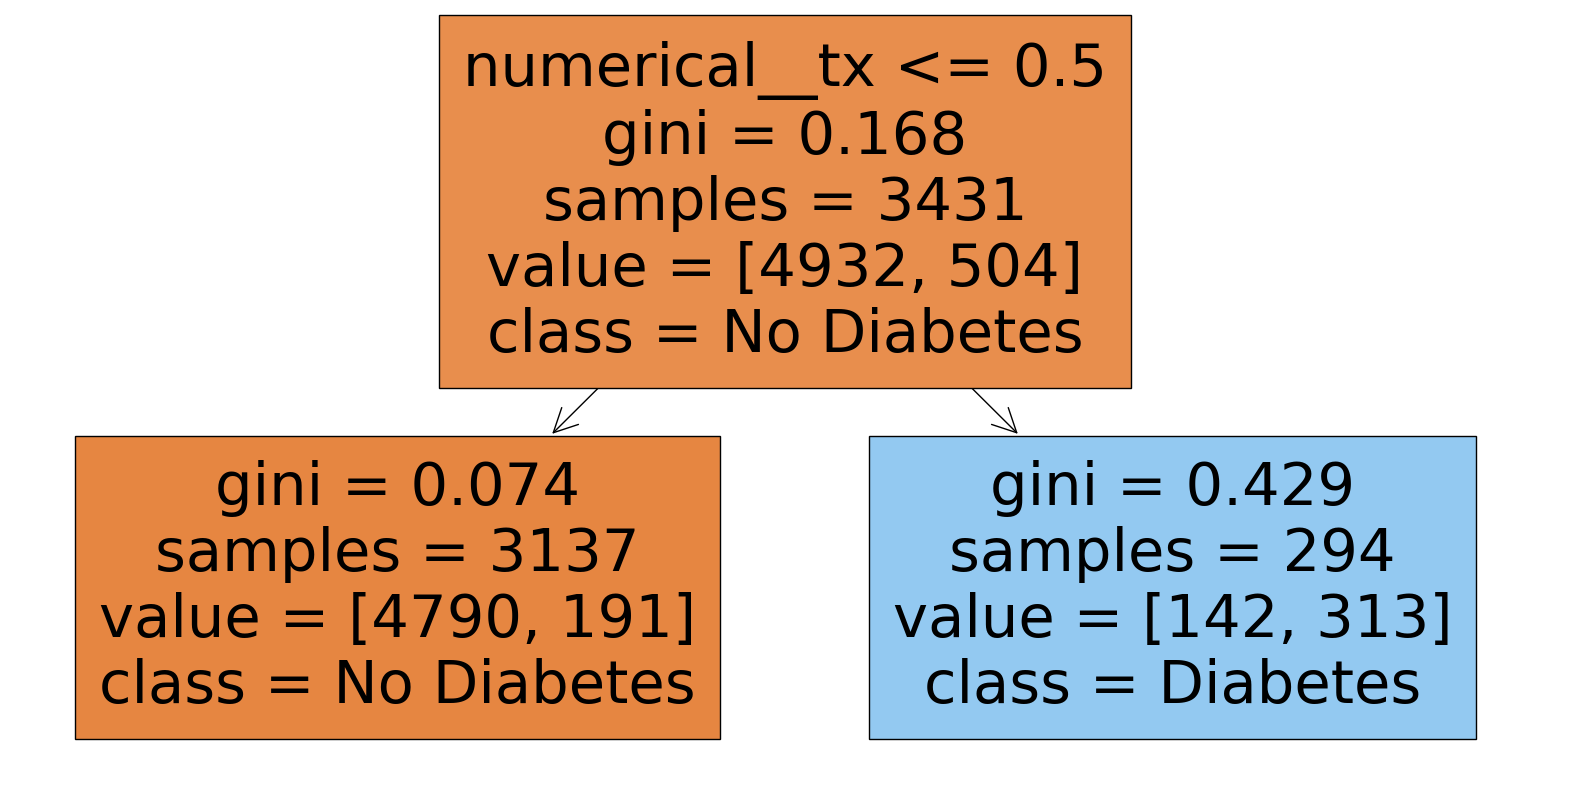

In [633]:
plt.figure(figsize=(20, 10))
plot_tree(best_rf.estimators_[0], feature_names=feature_names, filled=True, class_names=['No Diabetes', 'Diabetes'])
plt.show()

In [634]:
# Display feature importances
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature Importances:")
for i, idx in enumerate(indices):
    if importances[idx]==0:
      break
    print(f"{i + 1}. {feature_names[idx]}: {importances[idx]}")

Feature Importances:
1. numerical__tx: 1.0


# Model Evaluation

Based on the feature importance ranking retrieved from all models, I have identified tx and dx to be the most important variables.

My assumptions for diabetes prediction is that having more false positives is better than false negatives because it is more important for diabetic patients to receive treatment. Thus, more emphasis should be placed on minimizing the value in the bottom-left of the confusion matrix while maintaining the total false positive and false negatives at a low value.

The best model among the three is the random forest. It has the best accuracy and f1-score compared to others models. By comparing the diagram between decision tree and random forest, it can be observed that the random forest is a pruned version of the decision tree which prevents overfitting. The logistic regression model has a high false negative rate compared to the other models.